In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
from torchvision import models
from torch.nn.functional import relu, softmax, one_hot
from IPython.display import clear_output

1. Data preperation (preprocess)

NOTE TO SELF: The images should be of consistent dimensions for better results. This notebook specifically overfits one case. Although UNET is fully convolutional, the dimensions must be divisible by the downsampling operations (dimensions%2^n = 0)

In [2]:
img = cv2.imread('../data/raw/images/8013620831-0043.jpg-t.jpg')
mask = cv2.imread('../data/raw/masks/8013620831-0043.jpg-t.png')
img = img / 255.0

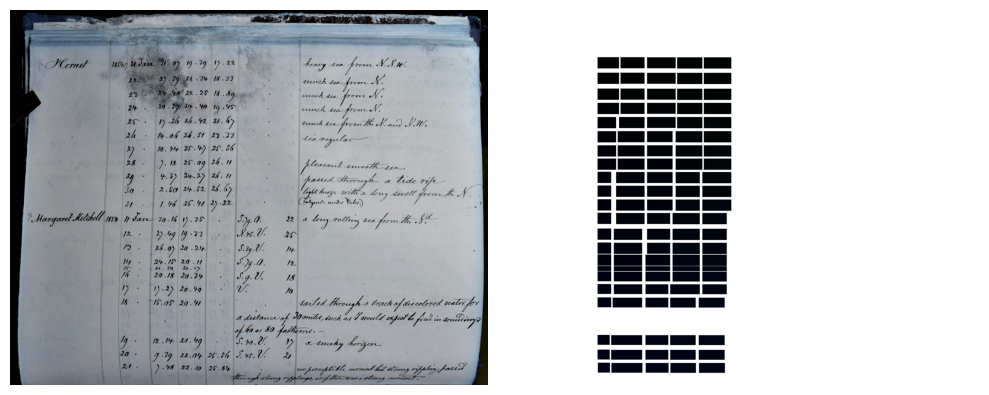

In [3]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.axis('off')

plt.tight_layout()
plt.show()

In [4]:
# red = rows
# green = columns (we care about this)
green_channel = mask[:, :, 1] # 1 for green since (R, G, B)
class_mask = np.zeros_like(green_channel)

class_mask[green_channel == 1] = 0  # Year 
class_mask[green_channel == 2] = 1  # Date
class_mask[green_channel == 3] = 2  # Latitude
class_mask[green_channel == 4] = 3  # Longitude
class_mask[green_channel == 5] = 4  # Water Temperature
class_mask[green_channel == 255] = 5  # Background

mask_class = torch.tensor(class_mask, dtype=torch.long)
one_hot_mask = one_hot(mask_class, num_classes=6)

print(one_hot_mask.shape)  # [height, width, num_classes]

torch.Size([2816, 3581, 6])


Checking if we have correctly one-hot encoded the classes (being columns and background)

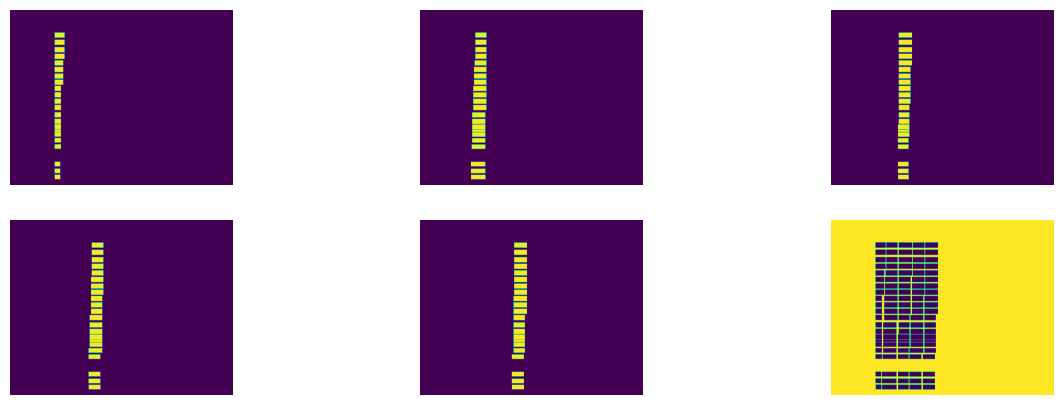

In [5]:
plt.figure(figsize=(15, 5))

for i in range(0, 6):
    plt.subplot(2, 3, i+1)
    plt.imshow(one_hot_mask[..., i])
    plt.axis('off')

plt.show()


2. UNET

In [6]:
class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        
        # Encoder
        self.e11 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn11 = nn.BatchNorm2d(64)
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn12 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn21 = nn.BatchNorm2d(128)
        self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn22 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn31 = nn.BatchNorm2d(256)
        self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn32 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e41 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn41 = nn.BatchNorm2d(512)
        self.e42 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn42 = nn.BatchNorm2d(512)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e51 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.bn51 = nn.BatchNorm2d(1024)
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1)
        self.bn52 = nn.BatchNorm2d(1024)

        # Decoder
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.dbn11 = nn.BatchNorm2d(512)
        self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.dbn12 = nn.BatchNorm2d(512)

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.dbn21 = nn.BatchNorm2d(256)
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.dbn22 = nn.BatchNorm2d(256)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.dbn31 = nn.BatchNorm2d(128)
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.dbn32 = nn.BatchNorm2d(128)

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.dbn41 = nn.BatchNorm2d(64)
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.dbn42 = nn.BatchNorm2d(64)

        self.outconv = nn.Conv2d(64, n_class, kernel_size=1)
        
        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Encoder
        xe11 = relu(self.bn11(self.e11(x)))
        xe12 = relu(self.bn12(self.e12(xe11)))
        xp1 = self.pool1(xe12)

        xe21 = relu(self.bn21(self.e21(xp1)))
        xe22 = relu(self.bn22(self.e22(xe21)))
        xp2 = self.pool2(xe22)

        xe31 = relu(self.bn31(self.e31(xp2)))
        xe32 = relu(self.bn32(self.e32(xe31)))
        xp3 = self.pool3(xe32)

        xe41 = relu(self.bn41(self.e41(xp3)))
        xe42 = relu(self.bn42(self.e42(xe41)))
        xp4 = self.pool4(xe42)

        xe51 = relu(self.bn51(self.e51(xp4)))
        xe52 = relu(self.bn52(self.e52(xe51)))
        
        # Decoder
        xu1 = self.upconv1(xe52)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = relu(self.dbn11(self.d11(xu11)))
        xd12 = relu(self.dbn12(self.d12(xd11)))

        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = relu(self.dbn21(self.d21(xu22)))
        xd22 = relu(self.dbn22(self.d22(xd21)))

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = relu(self.dbn31(self.d31(xu33)))
        xd32 = relu(self.dbn32(self.d32(xd31)))

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = relu(self.dbn41(self.d41(xu44)))
        xd42 = relu(self.dbn42(self.d42(xd41)))

        out = self.outconv(xd42)
        
        return out

3. Training Configuration

In [7]:
# HYPERPARAMS
BATCH_SIZE = 4
EPOCHS = 100
LEARNING_RATE = 1e-4
N_CLASSES = 6
TARGET_SIZE = (3200, 2496)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cuda


In [8]:
model = UNet(N_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

4. Train model

In [9]:
img_resized = cv2.resize(img, TARGET_SIZE, interpolation=cv2.INTER_AREA)
img_tensor = torch.from_numpy(img_resized).permute(2, 0, 1).float().unsqueeze(0).to(device)

mask_resized = cv2.resize(class_mask, TARGET_SIZE, interpolation=cv2.INTER_NEAREST)
mask_class_resized = torch.tensor(mask_resized, dtype=torch.long)
one_hot_mask_resized = one_hot(mask_class_resized, num_classes=6)
mask_tensor = one_hot_mask_resized.permute(2, 0, 1).float().unsqueeze(0).to(device)

In [10]:
scaler = torch.cuda.amp.GradScaler()
torch.cuda.empty_cache()

for epoch in range(EPOCHS):
    model.train()
    optimizer.zero_grad()
    # Forward pass with mixed precision
    with torch.cuda.amp.autocast():
        outputs = model(img_tensor)
        loss = criterion(outputs, mask_tensor)
    
    # Backward pass with gradient scaling
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
    
    # print text and visualization
    if (epoch + 1) % 5 == 0:
        clear_output(wait=True)
        with torch.no_grad():
            model.eval()
            pred = outputs.squeeze(0).cpu()
            pred = torch.argmax(pred, dim=0).numpy()
            
            plt.figure(figsize=(15, 5))
            
            plt.subplot(1, 3, 1)
            plt.imshow(img_resized)
            plt.title('Original Image (Resized)')
            
            plt.subplot(1, 3, 2)
            plt.imshow(mask_resized)
            plt.title('Ground Truth (Resized)')
            
            plt.subplot(1, 3, 3)
            plt.imshow(pred)
            plt.title(f'Prediction (Epoch {epoch+1}), Loss: {loss.item():.4f}')
            
            plt.suptitle(f'Loss: {loss.item():.4f}', fontsize=24)

            plt.show()

torch.save(model.state_dict(), 'overfitted_model.pth')

OutOfMemoryError: CUDA out of memory. Tried to allocate 976.00 MiB. GPU 